# Uebung 3 Merkmalsextraktion, binaere Klassifikation

Das Ziel dieser Übung ist die Integration der erlernten **Merkmalsextraktionsverfahren** in eine Klassifikationspipeline. Die einzelnen Schritte sind in der folgenden Abbildung veranschaulicht.

Dabei werdet ihr euch zunächst einmal der Unterscheidung von jeweils **zwei Klassen** widmen, also binären Klassifikationsproblemen. Nachdem ihr alle Aufgaben gelöst habt, könnt ihr die Anwendung für alle Klassen erweitern.

Das primäre Ziel ist der Aufbau einer **funktionierenden** Klassifikationspipeline und die Evaluation der Ergebnisse. Fokussiert euch zunächst auf die Implementierung. Wenn ihr alle Schritte implementiert und die Ergebnisse evaluiert habt, könnt ihr euch Gedanken über die Optimierung der Ergebnisse machen. 

Ihr werdet einen Subset aus dem **Industrial 100** Datensatz verwenden. Der Subset enthält die ersten 15 Klassen des Datensatzes. Eine Übersicht über alle ClassIDs und deren Bezeichnungen findet ihr in der csv-Datei **Industrial100-labels.csv**.


Den Datensatz könnt ihr von der tubCloud herunterladen und in den BGA2-Ordner ablegen (oder auf eurem eigenen Rechner). Anbei der **Link zum Datensatz**: https://tubcloud.tu-berlin.de/s/gWkS6eyoFemMXGz


<img src="./ipynb_bilder/klassifikationspipeline.png"  />

## Imports

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

from skimage.io import imread
from skimage import color, io
from skimage.transform import resize
from skimage.feature import hog, sift
from skimage import exposure

from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve, train_test_split, ShuffleSplit
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, precision_recall_curve
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from mpl_toolkits.mplot3d import Axes3D

from ipywidgets import interact, interactive, fixed, interact_manual, widgets

## Datenexploration
1. Schaut euch die ersten fünfzehn Klassen des Datensatzes "Industrial 100" an. Nutzt dafür euer Vorwissen (optional auch Hilfsfunktionen) aus Übung 1. Wählt für euch eine geeignete Methode (z.B. interaktive Anzeige mit ipywidgets.interact oder pyplot.subplots), um die 15 Klassen mitsamt ClassIDs und deren Bezeichnungen zu visualisieren. Ein Bild pro Klasse ist ausreichend. 
2. Wählt zwei Klassen aus, mit denen ihr die Klassifikationspipeline aufbaut. Dies könnt ihr im Laufe der Übung variieren, um schwierigere und leichtere Klassifikationsprobleme zu untersuchen, je nachdem ob die Klassen sehr ähnlich sind oder sich sehr unterscheiden. 


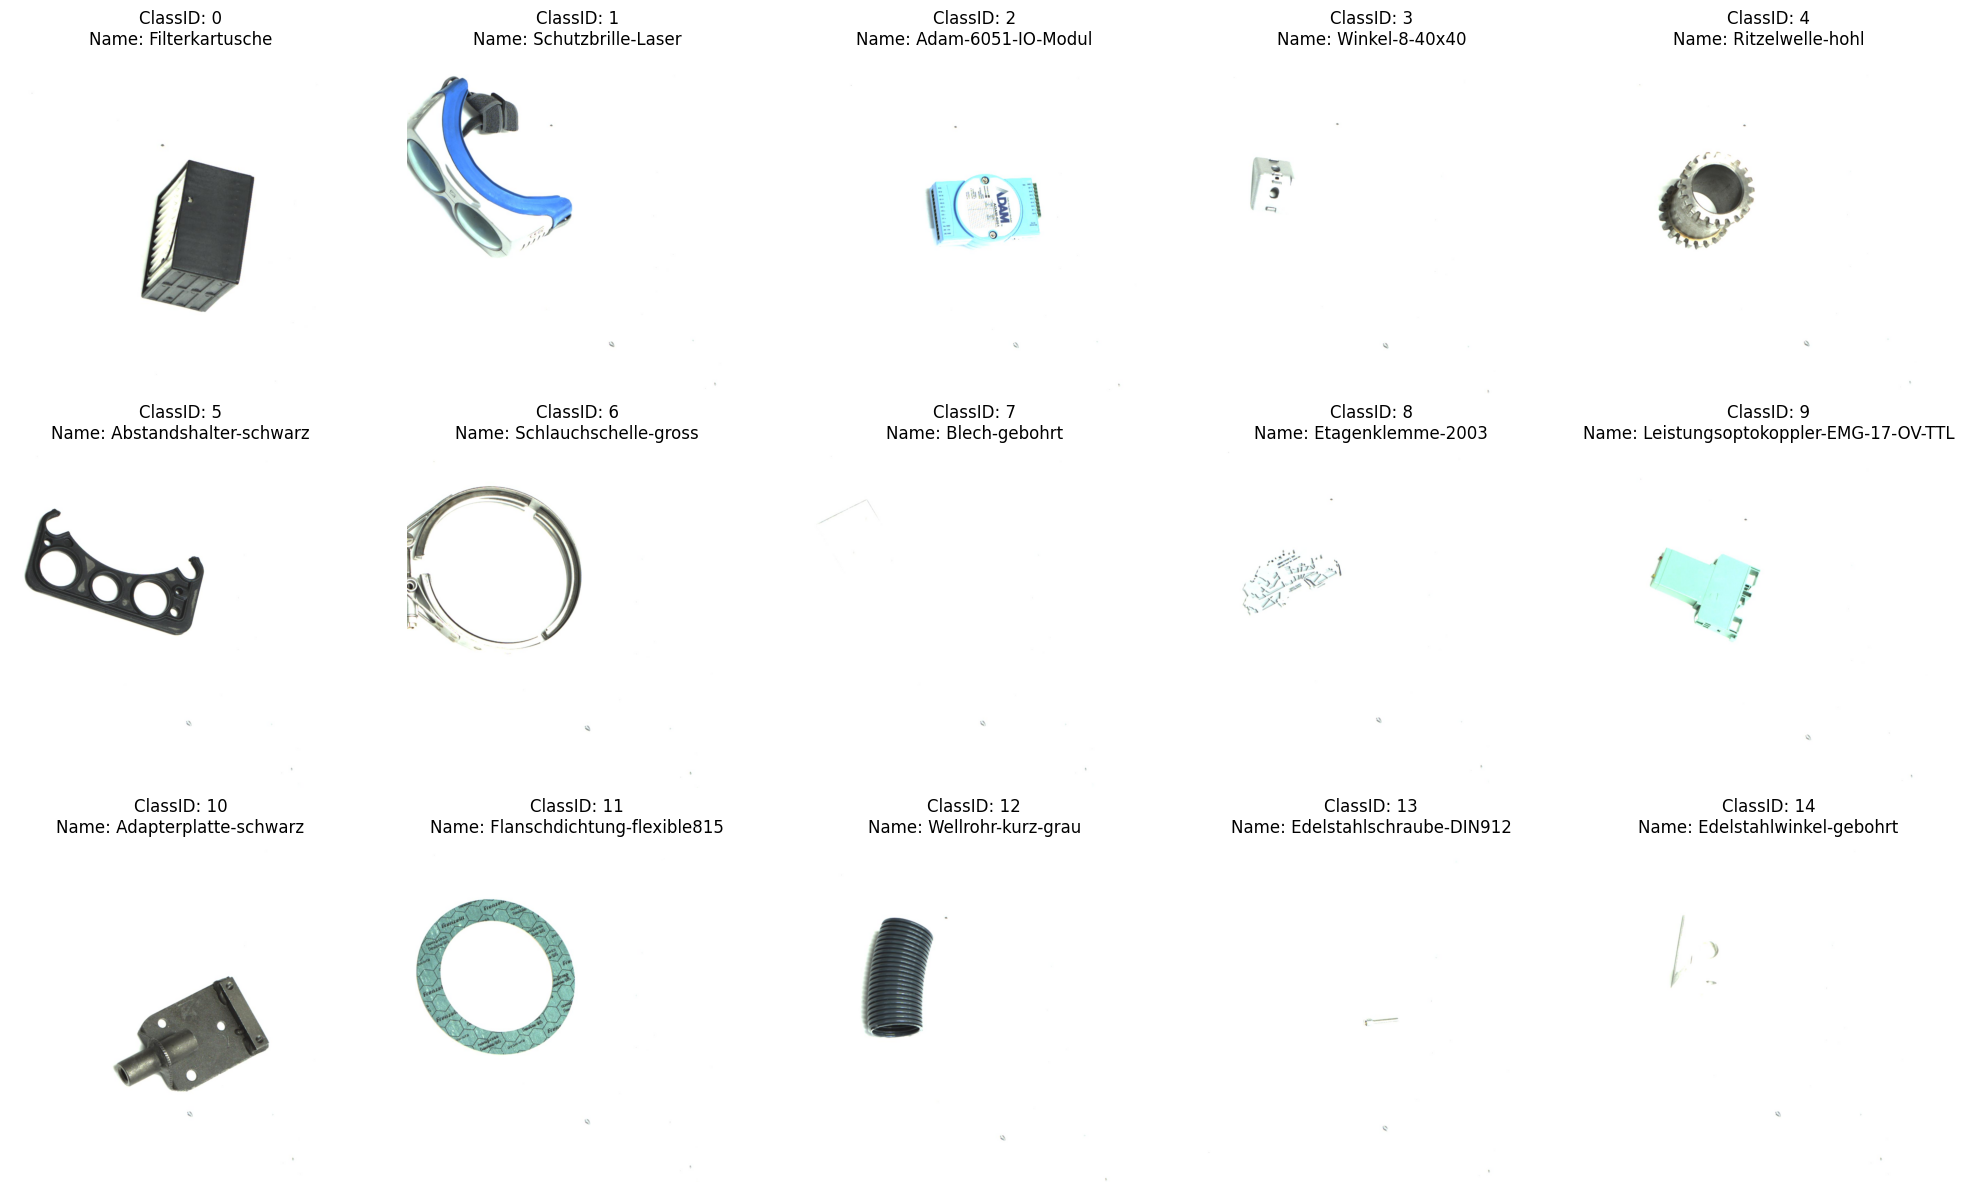

In [2]:
base_path = os.path.abspath('.')
file_path = os.path.join(base_path, 'SUBSET_Industrial_100_dataset', 'SUBSET_Industrial_100','Industrial100-labels.csv')
data = pd.read_csv(file_path, header=None, names=["ClassID", "ClassName"])

top_15_classes = data.head(15)

class_ids = top_15_classes["ClassID"].tolist()
class_names = top_15_classes["ClassName"].tolist()

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for ax, class_id, class_name in zip(axes, class_ids, class_names):
        folder_path = os.path.join(base_path, 'SUBSET_Industrial_100_dataset','SUBSET_Industrial_100',str(class_id))
        try:
            img_filename = os.listdir(folder_path)[0]
            img_path = os.path.join(folder_path, img_filename)
            img = mpimg.imread(img_path)
            ax.imshow(img)
            ax.set_title(f'ClassID: {class_id}\nName: {class_name}', fontsize=12)
            ax.axis('off')
        except (FileNotFoundError, IndexError):
            ax.text(0.5, 0.5, 'Image Not Found', ha='center', va='center', fontsize=12)
            ax.set_title(f'ClassID: {class_id}\nName: {class_name}', fontsize=12)
            ax.axis('off')

plt.tight_layout()
plt.show()

## Merkmalsextraktion
1. Extrahiert die [HOG](https://scikit-image.org/docs/0.20.x/auto_examples/features_detection/plot_hog.html#sphx-glr-auto-examples-features-detection-plot-hog-py)-Features für die von euch ausgewählten Klassen. Erweitert dafür euer Code aus Übung 2 so, dass ihr Features aus allen Bildern der beiden Klassen extrahiert.  
2. Unterteilt die Daten in Trainings- und Validierungsdaten. Ein mögliches Verhältnis wäre z.B. 75% Trainingsdaten und 25% Validierungsdaten. Dafür könnt ihr beispielsweise die [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.htmlhttps://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)-Funktion aus der scikit-learn-Bibliothek nutzen. 
3. Nachdem ihr alle Schritte der Klassifikationspipeline für HOG-Features implementiert habt, könnt ihr zu dieser Teilaufgabe zurückkehren und die SIFT-Features extrahieren und die Klassifikationspipeline mit SIFT-Features aufbauen.

In [3]:
base_path = os.path.abspath('.')
file_path = os.path.join(base_path, 'SUBSET_Industrial_100_dataset', 'SUBSET_Industrial_100','Industrial100-labels.csv')
data = pd.read_csv(file_path, header=None, names=["ClassID", "ClassName"])

top_15_classes = data.head(15)

class_ids = top_15_classes["ClassID"].tolist()
class_names = top_15_classes["ClassName"].tolist()

selected_classes = [1, 5]
class_names = data[data['ClassID'].isin(selected_classes)]['ClassName'].tolist()

def extract_hog_features(image_path):
    image = io.imread(image_path)
    
    if len(image.shape) > 2:
        image = color.rgb2gray(image)
        
    features, hog_image = hog(image, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=True)
    return features

features_list = []
labels_list = []

for class_id in selected_classes:
    folder_path = os.path.join(base_path, 'SUBSET_Industrial_100_dataset','SUBSET_Industrial_100',str(class_id))
    if os.path.exists(folder_path):
        print(f'Processing folder: {folder_path}')  
        for img_filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_filename)
            if img_filename.endswith(('.png', '.jpg', '.jpeg')):  
                try:
                    features = extract_hog_features(img_path)
                    features_list.append(features)
                    labels_list.append(class_id)
                except Exception as e:
                    print(f'Error processing file {img_path}: {e}')
            else:
                print(f'Skipping file {img_path}, not an image.')
    else:
        print(f'Folder {folder_path} does not exist.')


X = np.array(features_list)
y = np.array(labels_list)

print(f'Extracted HOG features shape: {X.shape}')
print(f'Labels shape: {y.shape}')

Processing folder: E:\lernen\TUB\ss2024\aBGA2\SUBSET_Industrial_100_dataset\SUBSET_Industrial_100\1
Processing folder: E:\lernen\TUB\ss2024\aBGA2\SUBSET_Industrial_100_dataset\SUBSET_Industrial_100\5
Extracted HOG features shape: (104, 864900)
Labels shape: (104,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f'Training features shape: {X_train.shape}')
print(f'Training labels shape: {y_train.shape}')
print(f'Testing features shape: {X_test.shape}')
print(f'Testing labels shape: {y_test.shape}')

Training features shape: (78, 864900)
Training labels shape: (78,)
Testing features shape: (26, 864900)
Testing labels shape: (26,)


In [5]:
file_path = "E:\\lernen\\TUB\\ss2024\\aBGA2\SUBSET_Industrial_100_dataset\\SUBSET_Industrial_100\\Industrial100-labels.csv"
data = pd.read_csv(file_path, header=None, names=["ClassID", "ClassName"])

selected_classes = [1, 5]
class_names = data[data['ClassID'].isin(selected_classes)]['ClassName'].tolist()

def extract_hog_features(image_path):
    try:
        image = io.imread(image_path)
        
        if len(image.shape) > 2:
            image = color.rgb2gray(image)
        
        features, hog_image = hog(image, pixels_per_cell=(8, 8),
                                  cells_per_block=(2, 2), visualize=True)
        return features
    except Exception as e:
        print(f'Error processing {image_path}: {e}')
        return None

base_path = "E:\\lernen\\TUB\\ss2024\\aBGA2\SUBSET_Industrial_100_dataset\\SUBSET_Industrial_100"

features_list = []
labels_list = []

for class_id in selected_classes:
    folder_path = os.path.join(base_path, str(class_id))
    if os.path.exists(folder_path):
        print(f'Processing folder: {folder_path}')  # 调试信息
        for img_filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_filename)
            if img_filename.endswith(('.png', '.jpg', '.jpeg')):  # 仅处理图像文件
                print(f'Processing file: {img_path}')  # 调试信息
                features = extract_hog_features(img_path)
                if features is not None:
                    features_list.append(features)
                    labels_list.append(class_id)
                else:
                    print(f'Skipping file {img_path}, failed to extract features.')
            else:
                print(f'Skipping file {img_path}, not an image.')
    else:
        print(f'Folder {folder_path} does not exist.')


if not features_list:
    raise ValueError("No features were extracted. Please check the image paths and extraction process.")

X = np.array(features_list)
y = np.array(labels_list)

print(f'Extracted HOG features shape: {X.shape}')
print(f'Labels shape: {y.shape}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f'Training features shape: {X_train.shape}')
print(f'Training labels shape: {y_train.shape}')
print(f'Testing features shape: {X_test.shape}')
print(f'Testing labels shape: {y_test.shape}')


Processing folder: E:\lernen\TUB\ss2024\aBGA2\SUBSET_Industrial_100_dataset\SUBSET_Industrial_100\1
Processing file: E:\lernen\TUB\ss2024\aBGA2\SUBSET_Industrial_100_dataset\SUBSET_Industrial_100\1\Industrial_1.jpg
Processing file: E:\lernen\TUB\ss2024\aBGA2\SUBSET_Industrial_100_dataset\SUBSET_Industrial_100\1\Industrial_10.jpg
Processing file: E:\lernen\TUB\ss2024\aBGA2\SUBSET_Industrial_100_dataset\SUBSET_Industrial_100\1\Industrial_11.jpg
Processing file: E:\lernen\TUB\ss2024\aBGA2\SUBSET_Industrial_100_dataset\SUBSET_Industrial_100\1\Industrial_12.jpg
Processing file: E:\lernen\TUB\ss2024\aBGA2\SUBSET_Industrial_100_dataset\SUBSET_Industrial_100\1\Industrial_13.jpg
Processing file: E:\lernen\TUB\ss2024\aBGA2\SUBSET_Industrial_100_dataset\SUBSET_Industrial_100\1\Industrial_14.jpg
Processing file: E:\lernen\TUB\ss2024\aBGA2\SUBSET_Industrial_100_dataset\SUBSET_Industrial_100\1\Industrial_15.jpg
Processing file: E:\lernen\TUB\ss2024\aBGA2\SUBSET_Industrial_100_dataset\SUBSET_Industri

## PCA
Führt eine PCA auf den Daten aus und projiziert die Daten dann in den neuen Merkmalsraum. Das gibt euch Aufschluss darüber, wie schwierig euer Klassifikationsproblem ist beziehungsweise wie gut eure Features geeignet sind, um die Klassen zu unterscheiden. 

Unter folgendem [Link](https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py) findet ihr ein Beispiel (2D PCA für den Iris-Datensatz)

Nachdem ihr alle Schritte der Klassifikationspipeline implementiert und eure Ergebnisse evaluiert habt, könnt ihr die Klassifikation mit den durch die PCA reduzierten Feature-Vektoren durchführen und die Ergebnisse mit den Ergebnissen ohne PCA vergleichen. 
Konntet ihr die Unterschiede feststellen?

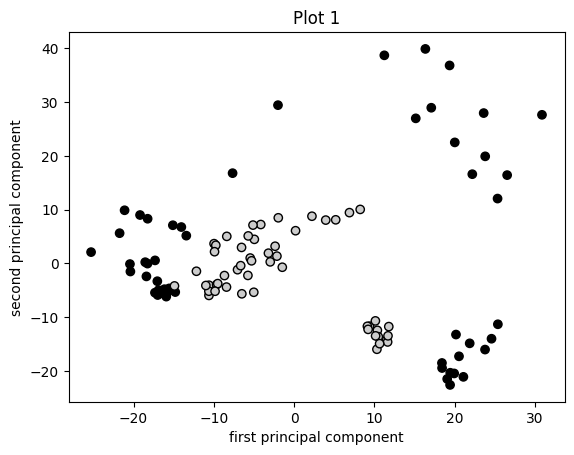

In [36]:
#Anbei ein Codesnippet für die Berechung und für die Visualisierung der PCA für die ersten zwei Hauptkomponenten 
# TO DO: definiere X- und y-Variablen
X = np.array(features_list)
y = np.array(labels_list)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.title('Plot 1')
plt.scatter(X2D[:, 0], X2D[:, 1],c=y, cmap=plt.cm.nipy_spectral,edgecolor='k')
plt.show()

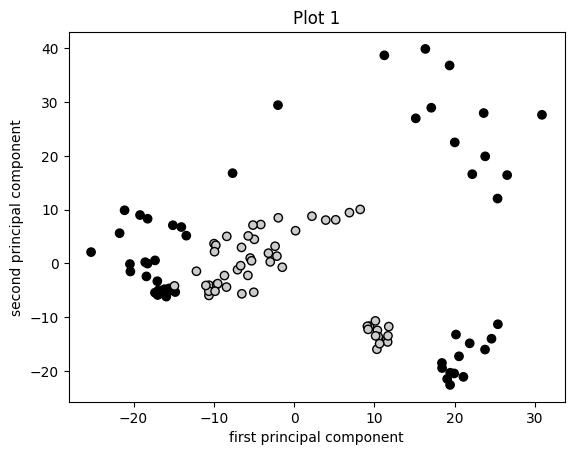

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.title('Plot 1')
plt.scatter(X2D[:, 0], X2D[:, 1],c=y, cmap=plt.cm.nipy_spectral,edgecolor='k')
plt.show()

In [34]:
len(X2D)
X2D[0]


array([-17.32600698,   0.54935003])

## Klassifikation
Für diese Teilaufgabe könnt ihr [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html) Klassifikator, 
 [SVM](https://scikit-learn.org/stable/modules/svm.html)-Klassifikator oder [MLP](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)-Klassifikator der scikit-learn-Bibliothek ausprobieren.

In [35]:
#SVM
from sklearn import svm
clf = svm.SVC()
clf.fit(X2D, y)
clf.predict([[-17.32600698,   0.54935003]])

array([1])

In [ ]:
# Anwendungsbeispiel für Naive Bayes Klassifikator
#gnb = GaussianNBnNBnNB()
# TO DO: Passe die Input- und Output-Parameter entsprechend den von dir gewählten Variablennamen an 
#y_pred = gnb.fit(X_train, y_train).predict(X_test)
#print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

In [ ]:
clf.predict()

## Evaluation
Zur Beurteilung der Klassifikationsleistung des Klassifikators könnt ihr die CCR auf den Validierungsdaten berechnen und euch die Konfusionsmatrix anschauen. Dafür könnt ihr beispielsweise die [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)-Funktion, die [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html?highlight=confusion#sklearn.metrics.confusion_matrix)-Funktion, [f1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)-Funktion der scikit-learn-Bibliothek nutzen. Experimentiert ein wenig und vergleicht die Ergebnisse für verschiedene Klassen und Konfigurationen eures Klassifikators.


Optional: Erstellung der Lernkurve
Das Ziel ist, zu schauen, wie sich die Fehler auf den Trainings- und Validierungsdaten mit der Menge der genutzten Trainingsdaten verändern. Dies wird Aufschluss darüber geben, wie ihr eure Klassifikationsleistung am effektivsten verbessern könnt. Man kann daraus ablesen, ob z.B. die Features ungeeignet sind oder das Modell des Klassifikators zu simpel ist, oder ob z.B. mehr Trainingsdaten helfen würden um die Klassifikationsleistung zu verbessern. Zur Erstellung der Lernkurve könnt ihr die [learning_curve](https://scikit-learn.org/stable/modules/learning_curve.html#learning-curve)-Funktion der scikit-learn-Bibliothek nutzen.

Nach dem Bearbeiten dieser Aufgabe sollt ihr folgende Fehlermaße / Gütekriterien definieren können und erklären, wofür sie verwendet werden: 
- accuracy score
- confusion matrix
- f1 score
- true positives
- true negatives
- false positives
- false negatives
- precision
- recall

### Accuracy

In [9]:
# TO DO: Passe die Input- und Output-Parameter entsprechend den von dir gewählten Variablennamen an 
accuracy_score = accuracy_score(y_test, y_pred)
print('Accuracy score for Classes X & Y is: {}'.format(accuracy_score))

Accuracy score for Classes X & Y is: 0.7307692307692307


### Confusion Matrix

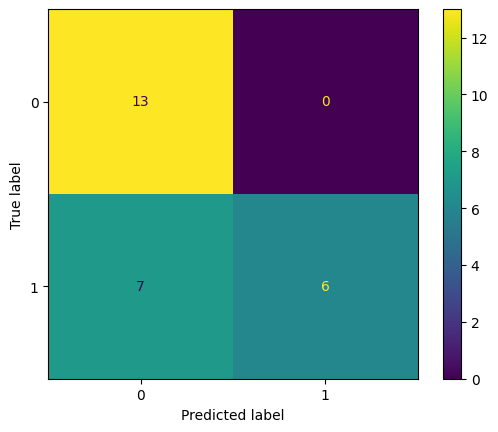

In [10]:
# TO DO: Passe die Input- und Output-Parameter entsprechend den von dir gewählten Variablennamen an 

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [11]:
# TO DO: Passe die Input- und Output-Parameter entsprechend den von dir gewählten Variablennamen an 

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)

13 0 7 6


### F1-Score
Schaut euch die [scikit-learn-Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) an, um die Ergebnisse zu interpretieren. Achtet dabei auf die Implementierung des **average**-Parameters.

In [12]:
# TO DO: Passe die Input- und Output-Parameter entsprechend den von dir gewählten Variablennamen an 
# Untersuche die Unterschiede für average='macro', average='micro', average='weighted', average=None
f1_score(y_test, y_pred, average='macro')

0.7097288676236044

### Precision / Recall

In [13]:
# TO DO: Passe die Input- und Output-Parameter entsprechend den von dir gewählten Variablennamen an 
# Untersuche die Unterschiede für average='macro', average='micro', average='weighted', average=None
# Link zur scikit-learn Doku: 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
precision_score(y_test, y_pred, average='macro')

0.825

In [14]:
# Link zur scikit-learn Doku: 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
recall_score(y_test, y_pred, average='macro')

0.7307692307692308